<a href="https://colab.research.google.com/github/hirotakaster/imagesearch/blob/main/nns_faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faissインストール
FaissはGPUを利用する。ランタイムの設定でGPUを有効にしておく。

In [1]:
# Faiss のインストール
# !pip install faiss-cpu
!pip install faiss-gpu
!pip install torchinfo
!git clone https://github.com/hirotakaster/imagesearch

     |████████████████████████████████| 85.5 MB 97 kB/s 
Cloning into 'imagesearch'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 144 (delta 1), reused 140 (delta 0), pack-reused 0
Receiving objects: 100% (144/144), 37.67 MiB | 33.34 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
# 画像表示用
import cv2
import matplotlib.pyplot as plt

def show_image_files(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, f in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB))

# 特徴量を取得するPytorchのモデル準備
・最後の全結合(Linear)を除去して特徴量として利用するが、RESNET 152のレイヤーを表示する。

In [3]:
import torch
import faiss
import matplotlib.pyplot as plt
import glob
import cv2
import os
from torchvision import transforms
from PIL import Image
from IPython.display import display
from torchinfo import summary

pointmodel = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
#pointmodel = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
pointmodel.eval()
print(summary(pointmodel, input_size=(2, 3, 224, 224)))

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 112, 112]         128
├─ReLU: 1-3                              [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [2, 64, 56, 56]           --
├─Sequential: 1-5                        [2, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [2, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [2, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [2, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [2, 64, 56, 56]           --
│ 

# ■ 全結合層を差し替えて特徴ベクトルとして利用する
・最後の全結合(Linear)をIdentityに差し替え。レイヤーを出力している。

・最後のレイヤーが変わっていることに注意。

In [4]:
pointmodel.fc = torch.nn.Identity() 
pointmodel.eval()
print(summary(pointmodel, input_size=(2, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [2, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 112, 112]         128
├─ReLU: 1-3                              [2, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [2, 64, 56, 56]           --
├─Sequential: 1-5                        [2, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [2, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [2, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [2, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [2, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [2, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [2, 64, 56, 56]           --
│ 

# ■ Faiss用インデックスの作成

In [5]:
# Faiss Indexの作成
faissidx = faiss.IndexFlatL2(2048)

# 推論の準備
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
if torch.cuda.is_available():
    pointmodel.to('cuda')

# 訓練データを読み込み・推論実行
files = glob.glob("imagesearch/data/train/*.jpeg")
for f in files:
  input_image = Image.open(f)
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = pointmodel(input_batch)
  n = output.to('cpu').detach().numpy().copy()

  # faiss indexに登録
  faissidx.add(n.reshape(-1, 2048))

# indexの保存
cpu_index = faiss.index_gpu_to_cpu(faissidx)
faiss.write_index(cpu_index, 'imagesearch/data/imageidx.faiss')


# Faissで画像探索

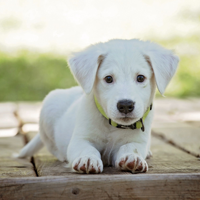

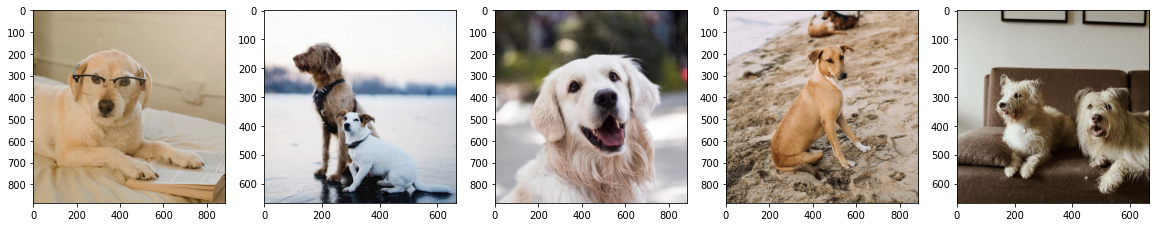

In [6]:
# 検索対象画像の特徴ベクトルを取得
input_image = Image.open("imagesearch/data/test/008.jpeg")
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# GPUに転送
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

# 推論実行
with torch.no_grad():
  output = pointmodel(input_batch)
n = output.to('cpu').detach().numpy().copy()

display(input_image.resize((200, 200)))

# faissで近傍探索実行、5件表示する
d, i = faissidx.search(n.reshape(-1, 2048), 5)
hitfiles = map(lambda f: files[f], i[0][::])
show_image_files(list(hitfiles))